                                    Particle filter with GMM likelihood representation  

This code implements particle filter with GMM representation as proposed in Gallant et al (2016) for a stochastic volatility in Julia language. It can be employed when one does not want to rely on the structural form of the measurement equation

In [1]:
versioninfo()

Julia Version 1.1.1
Commit 55e36cc308 (2019-05-16 04:10 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-4500U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)


Simulate a stochastic volatility as in "1. Bootstrap particle filter"

A hidden Markov process $\left \{ X_{t} \right \}_{t\geq 1}$ and a vector of observables $\left \{ Y_{t} \right \}_{t\geq 1}$ are generated from

\begin{align*}
X_{t}|X_{t-1} &=x_{t-1}\sim f_{\theta}(x_{t}|x_{t-1}), \qquad X_{1}=x_{1}\sim \mu_{\theta}(x_{1});\\
Y_{t}|X_{t}&=x_{t}\sim g_{\theta}(y_{t}|x_{t}).
\end{align*}

In particular the stochastic volatility considered here takes the following form

\begin{align*}
X_{t}&=\alpha\, X_{t-1} + \sigma V_{t}\\
Y_{t}&=\beta\,exp\left \{ X_{t}/2 \right \}\zeta_{t}
\end{align*}

where the error terms are distributed
according to

\begin{equation}
\binom{V_{t}}{\zeta_{t}}\overset{iid}{\sim} N
\begin{pmatrix}\begin{matrix}
\begin{pmatrix}
0\\ 
0
\end{pmatrix}
\end{matrix},
\begin{pmatrix}
 \sigma^2 & 0\\ 
 0 & 1
\end{pmatrix}
\end{pmatrix}\nonumber.
\end{equation} 

Data are generated by setting the vector of structural parameters $\theta=\left ( \alpha, \sigma, \beta \right )$ to be $\theta_{\circ}=\left ( 0.9,\, 1\, , 0.7 \right )$ over a sample size $t = 1,2,...,T$, with $T=300$.

In [2]:
using Distributions    
using Optim
using Random                  
using Plots
using Calculus
using StatsFuns
using StatsBase 
using LinearAlgebra
using JLD

In [3]:
# Simulate stochastic volatility

θ = [.9, 1, 0.7];    # Define the vector of parameters
T = 300;             # Series length

function simSV(θ, T)
    Random.seed!(123);
    
    α, σ, β = θ
    println("Simulating SVM")
    println("α = ", α, ", σ = ", σ, ", β = ", β)    
    X = Array{Float64}(undef,T+1)
    Y = Array{Float64}(undef,T)
    X[1] = 0.0
    for t = 1:T
        X[t+1] = α*X[t] + σ*randn()
        Y[t]   = β*exp(X[t]/2)*randn()
    end
    return Y, X
end

Y, X = simSV(θ, T);

Simulating SVM
α = 0.9, σ = 1.0, β = 0.7


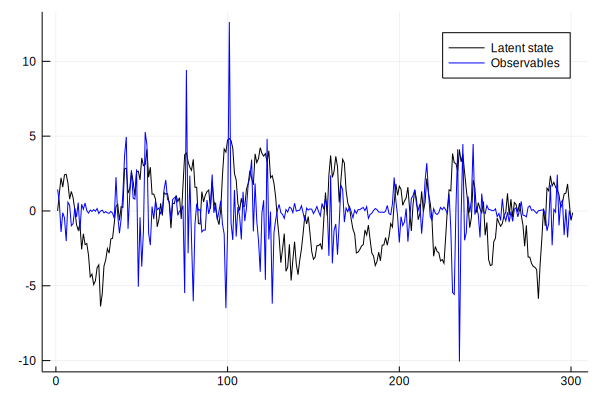

In [4]:
# Plot Observables vs Latent state

plot(X,line=(:black, 1, 1,:solid),label="Latent state")
plot!(Y,line=(:blue, 1, 1,:solid),label="Observables")

In [20]:
################################################################################################################################

                                             GMM Particle filter algorithm

$\textit{Initialization}.$ Set $t\leftarrow 1. $ For $i=1:N$:

[(1)] Sample $\tilde X^{i}_{1}\sim \mu_{\theta}\left ( x_{1} \right )$

[(2)] Compute the weights $W^{i}_{1} \propto\alpha^{i}_{1}\left (\tilde X^{i}_{1}\right )$, with $\alpha^{i}_{1}\left (\tilde X^{i}_{1}\right ) =p^{\ast}\left ( y_{1}|\tilde X^{i}_{1}, \theta \right )$

[(3)] Resample from $\left \{ W^{i}_{1}, \tilde X^{i}_{1} \right \}_{i=1}^{N}$ to obtain $\left \{ 1/N,  X^{i}_{1} \right \}_{i=1}^{N}$

$\textit{Iteration}$. At time $t \geq  2$, for $i=1:N$:

[$(1)$] Sample $\tilde X^{i}_{t}\sim f_{\theta}\left ( x_{t}| X^{i}_{t-1} \right )$

[(2)] Compute the weights $W^{i}_{t} \propto\alpha^{i}_{t}\left ( X^{i}_{1:t-1},\tilde X^{i}_{t} \right  )W^{i}_{t-1}$,
with $\alpha^{i}_{t}\left (X^{i}_{1:t-1},\tilde X^{i}_{t} \right ) =p^{\ast}\left ( y_{t}|X^{i}_{1:t-1},\tilde X^{i}_{t}, \, \theta \right )$

[(3)] Set $\left \{\tilde X^{i}_{1:t} \right \}\leftarrow \left \{ X^{i}_{1:t-1},\tilde X^{i}_{t} \right \}$

[(4)] Resample from $\left \{ W^{i}_{t},\tilde X^{i}_{1:t} \right \}_{i=1}^{N}$ to obtain $\left \{ 1/N, X^{i}_{1:t} \right \}_{i=1}^{N}$

where the normalized weights are defined as 

$$
W_{t}^i=\frac{\alpha_{t}^i\left ( \tilde X^{i}_{t} \right )W_{t-1}^i}{\frac{1}{N}\sum_{i=1}^{N} \alpha_{t}^{i}\left ( \tilde X^{i}_{t} \right )W_{t-1}^i}.
$$ 

Notice that it is similar to the standard particle filter, but the incremental weights have a GMM representation

$$\alpha_{t}\left ( \tilde x_{t} \right ) = p^{\ast}\left ( y_{t}|x_{1:t-1},\tilde x_{t}, \theta \right ).$$

where 

$$p^{\ast}(y_{t}|x_{1:t-1},  x_{t})=
(2\pi)^{-\frac{M}{2}}\,exp\left \{ g_{t}(y_{1:t},x_{1:t-1}, x_{t})'\, \Sigma(y_{1:t}, x_{1:t-1}, x_{t}) ^{-1} g_{t}(y_{1:t},x_{1:t-1}, x_{t}) \right \}$$

where the function $g_{t}$ is constructed upon moment conditions

$g_{1}=y_{t}^{2}-\beta^{2}\,exp\left(x_{t}\right)$

$g_{2}=|y_{t}|-\sqrt{\left (\frac{2}{\pi}  \right )}\,\beta\,exp\left ( \frac{x_{t}}{2} \right )$

$g_{3}=|y_{t}|\,|y_{t-1}|-\left (\frac{2}{\pi}  \right ) \,\beta^2\,exp\left ( \frac{x_{t}}{2} \right )\,exp\left ( \frac{x_{t-1}}{2} \right )$

$\vdots$

$g_{s+2}=|y_{t}|\,|y_{t-s}|-\left (\frac{2}{\pi}  \right ) \,\beta^2\,exp\left ( \frac{x_{t}}{2} \right )\,exp\left ( \frac{x_{t-s}}{2} \right )$

$g_{s+3}=x_{t-1}\,\left (x_{t} - \alpha\,x_{t-1}  \right)$

$g_{s+4}=\left (x_{t} - \alpha\,x_{t-1}  \right)^{2}-\sigma^{2}$

The sample moment conditions can be then normalized by the weighting matrix $\Sigma$

$$Z_{1:T}(y_{1:T},x_{1:T},\theta)= \left [ \Sigma(y_{1:T}, x_{1:T}, \theta) \right ]^{-1/2} g_{T}(y_{1:T},x_{1:T}, \theta) $$

where

$$g_{T}(y_{1:T},x_{1:T}, \theta)=\frac{1}{\sqrt{T}}\sum_{t=1}^{T}g(y_{t},x_{t}, \theta)$$

$$
\Sigma(y_{1:T}, x_{1:T}, \theta)=\frac{1}{T}\sum_{t=1}^{T}\left [ \widetilde{g}(y_{t},x_{t},\theta)\right ]\left [  \widetilde{g}(y_{t},x_{t},\theta)\right ]^{'}
$$

$$
\widetilde{g}(y_{t},x_{t},\theta)=g(y_{t},x_{t},\theta)-\frac{1}{\sqrt{T}}g_{T}(y_{1:T},x_{1:T}, \theta).
$$

In [11]:

N=1000  #Define the number of Particles to sample at each t

M = 4;              #Define the number of moment conditions
T₀ = 1  #2          #The Smallest Number needed to initialize the GMM recursion  

# Define function to be used inside particle filter   

# 1. Initial Condition latent state (stationarity condition is assumed)
function sampIC!(θ,l)
    α, σ, β = θ
    rand!(Normal(0, sqrt(σ^2/(1-α^2))), view(l,:,1))
end

# 2. Define incremental weights 
function normpdf!(θ,l,Y)
    α, σ, β = θ
    pdf(Normal(0, exp(l/2)), Y)
end

# 3. Simulate latent state
function sampREC!(θ,l)
    α, σ, β = θ
    rand(Normal(α*l, σ))
end

# 4. Define moment conditions
function gMoments!(l,Y,g,θ,t)                                     
    α, σ, β = θ 
    
    g[1,t] = Y[t]^2 - β^2*exp(l[t])
    g[2,t] = sqrt(abs2(Y[t]))*sqrt(abs2(Y[t-1])) - β^2*(2/π)*exp(l[t]/2)*exp(l[t-1]/2)
    g[3,t] = l[t-1]*(l[t] - α*l[t-1])
    g[4,t] = (l[t]-α*l[t-1])^2 - σ^2
    
    return g
end

# 5. Resample step
function resample!(l, F, idx)
    N =  size(l, 1)
    sample!(1:N, Weights(F), idx)
    for i = eachindex(l)
        @inbounds l[i] = l[idx[i]]
        end    
    l
end

# 6. GMM representation for the predictive measurement density 
function Z(M,l)
    Tph = size(l,1)                                          #Partial history
      g = Array{Float64}(undef,M,Tph)
    
    @inbounds for t = T₀+1:Tph
        gMoments!(l,Y,g,θ,t) 
    end
    sg = (1/sqrt(Tph-T₀))*(sum(g[:,T₀+1:Tph],dims=2))         #(M x 1)
    dg = g[:,T₀+1:Tph].-(1/sqrt(Tph-T₀))*sg                   #(M x t)  
     Σ = (1/(Tph-T₀))*(dg*dg')                                #(M x M)
     Z = sg'*pinv(Σ)*sg                                       #(1 x 1)
    
    return Z[1]
end  

Z (generic function with 1 method)

In [12]:
# Particle filter with GMM likelihood representaation
function PGMM(θ,N,Y)
    #Definitions
          T = size(Y,1)
    α, σ, β = θ
          l = Array{Float64}(undef,N,T)    
          F = Array{Float64}(undef,N,T) 
        idx = Array{Int64}(undef,N)                                                                                                        
    
    #Latent State Initial Condition 
    sampIC!(θ,l)
    for i = 1:N
        F[i,1] = normpdf!(θ,l[i,1],Y[1])
    end
    #Log-likelihood initial condition
    llik = log(mean(F))
    #Resample Step Initial Condition
    resample!(view(l, :,1),F[:,1],idx)
    
    for t = T₀+1:T 
        sFRec=0.0
        for i = 1:N 
            #Latent State   
            l[i,t] = sampREC!(θ,l[i,t-1])
            #Particle Weights  
            F[i,t] = ((2*π)^(-M/2))*exp(-(1/2)*Z(M,l[i,1:t]))       #GMM likelihood representation
            sFRec += F[i,t]
        end
        #Log-likelihood
        @inbounds llik += log(sFRec)-log(N)
        #Resample Step
        resample!(view(l, :, t), F[:,t], idx)                               
    end
    #Rescaling
    return l,llik
end
nothing

In [14]:
# Run particle filter given the vector of true parameters 

@time l,llik = PGMM(θ, N, Y); 

 20.437209 seconds (71.90 M allocations: 11.509 GiB, 15.89% gc time)


Display log-likelihood function $ln\,\hat p(y_{1:T}|\theta_{\circ})$

In [11]:
llik

-3754.159044600322

Display mean and standard deviation of $\hat p(x_{t}|y_{1:t}, \theta_{\circ})$ for $t=1,2,...,300$

In [15]:
# [(1)] mean and standard deviation of the filtered latent state

X_est = Array{Float64}(undef,size(l,2))
V_est = Array{Float64}(undef,size(l,2))
SDmin = Array{Float64}(undef,size(l,2))
SDmax = Array{Float64}(undef,size(l,2))

for t = 1:size(l,2)
    X_est[t] = mean(l[:,t]);
    V_est[t] = var(l[:,t]);
end

 SDmin  = X_est[1:size(l,2)] - (V_est[1:size(l,2)]).^(1/2);
 SDmax = X_est[1:size(l,2)] + (V_est[1:size(l,2)]).^(1/2);

[(1)] Plot mean and standard deviation of $\hat p(x_{t}|y_{1:t}, \theta_{\circ})$ for $t=1,2,...,149$

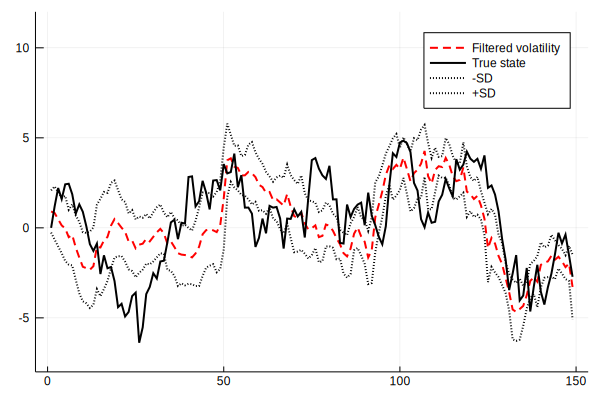

In [22]:
# Plot [(1)]

Start = 1
End   = 149

plot(Start:End,X_est[Start:End],line=(:red, 1, 2,:dash),label="Filtered volatility",ylims=(-8,12))
plot!(Start:End,X[Start:End],line=(:black, 1, 2,:solid),label="True state")
plot!(Start:End,SDmin[Start:End],line=(:black, 1, 2,:dot),label="-SD")
plot!(Start:End,SDmax[Start:End],line=(:black, 1, 2, :dot),label="+SD")  

[(2)] Plot mean and standard deviation of $\hat p(x_{t}|y_{1:t}, \theta_{\circ})$ for $t=150,...,300$

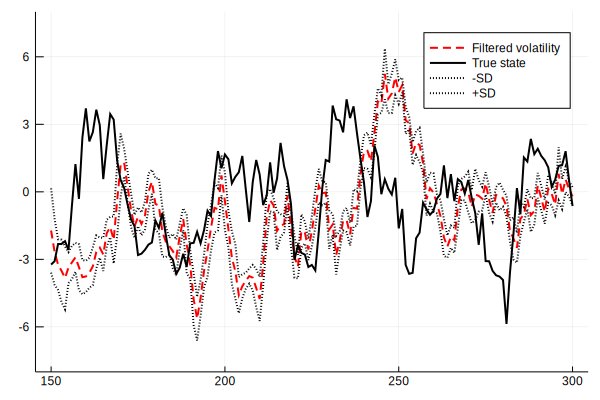

In [19]:
# Plot [(2)]

Start = 150
End   = size(X,1)-1

plot(Start:End,X_est[Start:End],line=(:red, 1, 2,:dash),label="Filtered volatility",ylims=(-8,8))
plot!(Start:End,X[Start:End],line=(:black, 1, 2,:solid),label="True state")
plot!(Start:End,SDmin[Start:End],line=(:black, 1, 2,:dot),label="-SD")
plot!(Start:End,SDmax[Start:End],line=(:black, 1, 2, :dot),label="+SD")  

GMM particle filter allows to relax the assumptions on the structural form of the measurement equation. On the other hand, it suffers from high degeneracy in the particle weights and the accuracy of Monte Carlo approximations decreases as $t$ increases. In fact, for $t = 1,2, ..., 149$ particle GMM can approximate the true state relatively well. For $t = 150,151, ..., 300$ the approximated state is misleading with respect the true one. The block-sampling strategy seems to drastically alleviate the depletion problem.